# Measuring and Recovering Tensor Data

In this notebook we measure a video a frame at a time using a leave-one-out procedure. To find a minimal set of requirements, see the ``requirements.txt`` at <https://github.com/cahaselby/leave_one_out_recovery>

In [1]:
import pandas as pd
import numpy as np
import tensorly as tl
from sklearn.cluster import KMeans
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import cv2
import timeit
import loo_recover as loo
from IPython.display import clear_output

The following cell will download the video into the same directory as the notebook. You may skip this block if you have downloaded the video by another method

In [2]:
import urllib
url_link = 'https://figshare.com/ndownloader/files/29084181'

file_name = 'walking_past_camera.mp4' 
urllib.request.urlretrieve(url_link, file_name) 

('walking_past_camera.mp4', <http.client.HTTPMessage at 0x7f28a8d65490>)

This generates the matrices to be used in measuring the tensor and places the ensemble in ``A_kron``

In [3]:
dim = 3 #three mode tensor
Trials = 1 #run the experiment once

M_c = (40,40,40) #sketching dimensions for the core measurements
R = (10,10,10) #rank to truncate to
M = (20,20,20) #sketching dimensions for the factors

side_lengths =(1080,1920,2200) #dimensions of the tensor: height x width x time

#generate a measurement ensemble that uses gaussian random variables
A_kron = loo.measurement_ensemble(dim,side_lengths,M_c,M,loo.my_random_matrix_generator,typ='g')

#for the sake of efficiency you could use identity matrices for the full rank measurement matrices in the ensemble.
#for j in range(dim):
#    A_kron[j][j] = np.eye(side_lengths[j])

#e.g. A_kron[0][1] would return the measurement matrix intended for use in the second mode for the measurement tensor B_0 
#B_0 leaves the first mode uncompressed

#The following would generate an ensemble that uses "RFD" random matrices which permit an FFT-type multiply
#A_kron_rfd = loo.measurement_ensemble(dim,side_lengths,M_c,M,loo.my_random_matrix_generator,typ='real_rfd')

Allocate memory for the measurement tensors used to estimate factor matrices e.g. $B_0 = (1080,20,20)$ and core $B_3 = (40,40,40)$. 

We then sketch the video one frame at a time, updating all the measurement tensors after each frame to demonstrate the measurements can be performed in one pass in a streaming setting.

In [5]:
frames_rgb_display = [] #We will take three frames for display that have the color channels
frames_gray = []

path = "walking_past_camera.mp4"
cap = cv2.VideoCapture(path)

B_kron = {} #This is where we will store the measurement tensors
meas_shapes = [] #we will put the shapes of the measurement tensors here, e.g. for the first mode (n,m,m)

#Allocate for the measurement tensors B_kron. 
for j in range(dim+1):
    if j<3:
        meas_shapes.append(list(M))
        meas_shapes[j][j] = side_lengths[j]
    else:
        meas_shapes.append(list(M_c))
        
    B_kron[j] = tl.zeros(meas_shapes[j])


offset_start = 100 #We skip the first 100 frames and the last 193 frames to remove the camera jiggle sections
offset_end = 2300

for f in range(offset_end):
    # read one frame from the 'capture' object, this is streaming one frame at a time
    #note we only need pass through the video once e.g. "Single-Pass"
    ret, img = cap.read() 
    
    clear_output(wait=True)
    print("Sketching frame: ", f+1, "/", 2300)
    if f < offset_start: continue
        
    if ret: 
        #keeping the frames in a tensor is not necessary (and potentially memory intensive) 
        #however, for comparison purposes in this case we keep the frames
        frames_gray.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255)
       
        k = f-offset_start
        Xk = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) / 255
        for j in range(dim+1):
            starttime = timeit.default_timer()
            
            B_prime = (A_kron[j][0] @ Xk @ A_kron[j][1].T)
     
            for q in range(B_prime.shape[1]):
                for p in range(B_prime.shape[0]):
                    B_kron[j][p,q,:] = B_kron[j][p,q,:] + B_prime[p,q]*A_kron[j][2][:,k]
            
        #Keep three frames for display
        if f in [0+offset_start,1000+offset_start,1454+offset_start]:
            frames_rgb_display.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

video = np.stack(frames_gray, axis=0)

Sketching frame:  2300 / 2300


A figure that shows three frames throughout the video

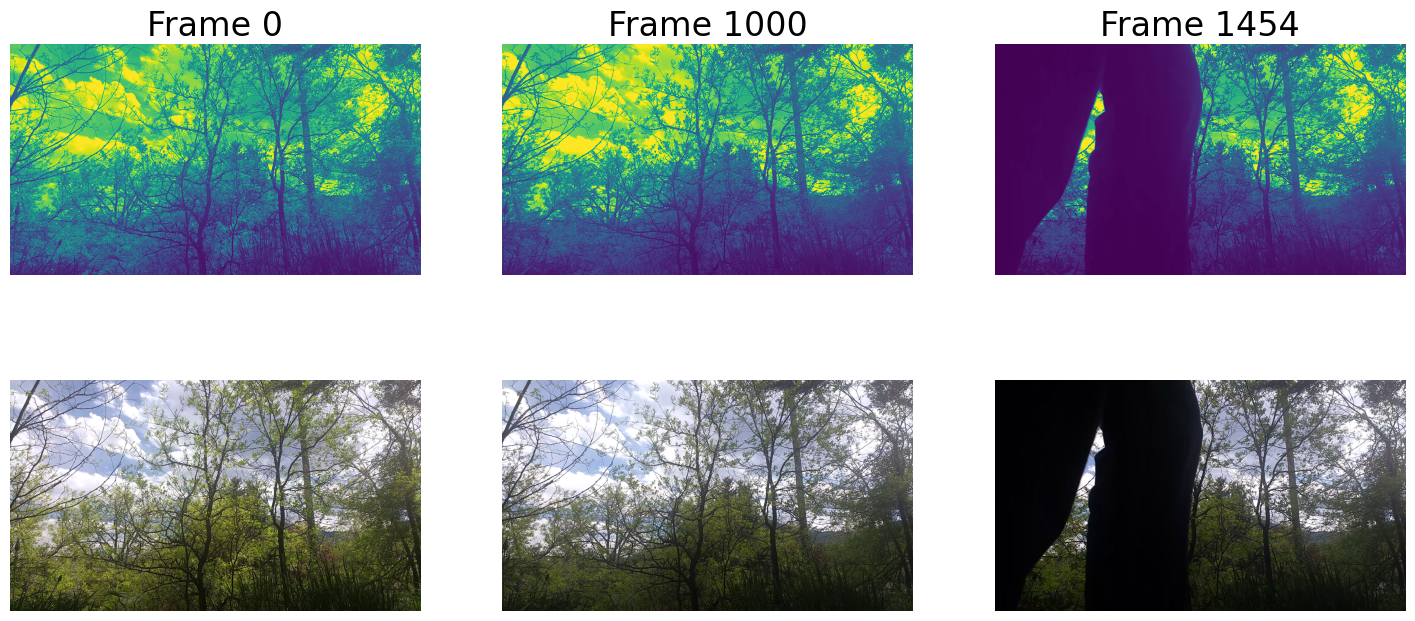

In [7]:
fig, ax = plt.subplots(2,3, figsize=(18,8))
plt.rcParams['font.size'] = 20

plt.subplot(2,3,1)
plt.axis('off')
plt.title('Frame 0')
plt.imshow(video[0,:,:])

plt.subplot(2,3,2)
plt.axis('off')
plt.title('Frame 1000')
plt.imshow(video[1000,:,:])

plt.subplot(2,3,3)
plt.axis('off')
plt.title('Frame 1454')
plt.imshow(video[1454,:,:])

plt.subplot(2,3,4)
plt.axis('off')
plt.imshow(frames_rgb_display[0])

plt.subplot(2,3,5)
plt.axis('off')
plt.imshow(frames_rgb_display[1])

plt.subplot(2,3,6)
plt.axis('off')
plt.imshow(frames_rgb_display[2])
plt.show()

We recover the tensor by solving a least square problem defined by the measurements

In [8]:
#Have the stacked frames match the H x W x Time arrangement of modes
video = np.moveaxis(video, 0,2)

# Recovery, using measurements in tasks

It is possible then to recover a quasi-optimal tensor at the chosen rank truncation level using several methods, for example a least square solve using only the information from the measurements

In [9]:
#Solve using least squared the factor matrices and core using the measurements
starttime = timeit.default_timer()
S_tilde,U = loo.lsmlsvd_brks(A_kron,B_kron,R,mode='kron')    
T_hat_one_pass_fast = tl.tucker_tensor.tucker_to_tensor((S_tilde,U))
print("recover time: ", timeit.default_timer() - starttime)

recover time:  13.9573625754565


Relative error - this does naturally require another access to the original data

In [10]:
#Calculate the relative error. The tensor is not especially low rank, but the point is the useful information is 
#preserved in the recovered tensor
rel_error_one_pass = loo.eval_rerr(video,T_hat_one_pass_fast,video)
print("Relative Error of one pass:", rel_error_one_pass)

Relative Error of one pass: 0.39700026810809275


Can use a second pass of the video to calculate a core

In [11]:
#Using a second pass of the data, calculate the optimal core for the given factor matrices found earlier in the one-pass
T_hat_two_pass_fast = tl.tucker_tensor.tucker_to_tensor((tl.tenalg.multi_mode_dot(video,U,transpose=True),U))
rel_error_two_pass = loo.eval_rerr(video,T_hat_two_pass_fast,video)
print("Relative Error of two pass:", rel_error_two_pass)

Relative Error of two pass: 0.3671547302266512


## Comparing $k$-means on the factor, recovered tensors

We proceed to perform clustering to see if we can identify the sequences of interest in the video (the man walking in front of the camera in frame 1454 from above for example). We will cluster on

1) Factor matrix from the time mode, e.g. U_2 in (n_2, r_2) = (2200,10)
2) Measurements that leave out the time mode unfolded, e.g. B_2_[2]  in (m_0 * m_1, n_2) =  (40,2200)
3) Unfolded one-pass recovered tensor T_1_[2] in (n_0 * n_1, n2) = (2073600,2200)
4) Unfolded two-pass recovered tensor or T_2_[2] in (n_0 * n_1, n2) = (2073600,2200)

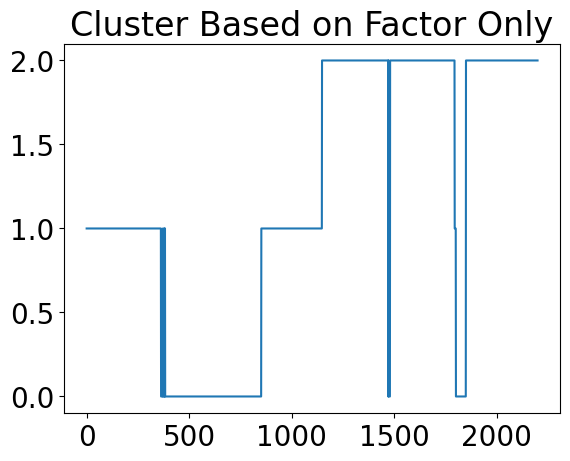

In [28]:
kmeans_factor_fast = KMeans(n_clusters=3,n_init="auto").fit(U[2])
plt.title("Cluster Based on Factor Only")
plt.plot(kmeans_factor_fast.labels_)

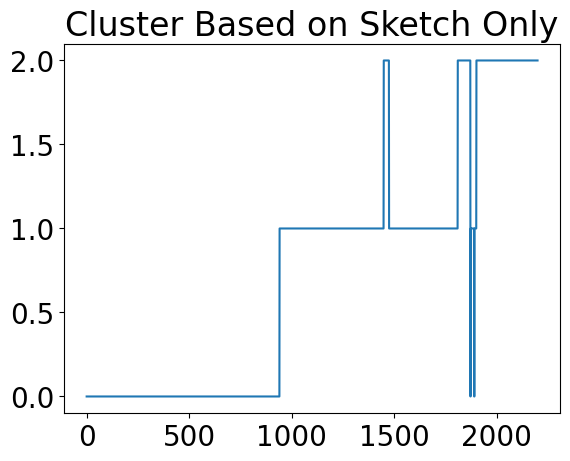

In [25]:
kmeans_sketch_fast = KMeans(n_clusters=3,n_init="auto").fit(tl.unfold(B_kron[2],2))
plt.title("Cluster Based on Sketch Only")
plt.plot(kmeans_sketch_fast.labels_)

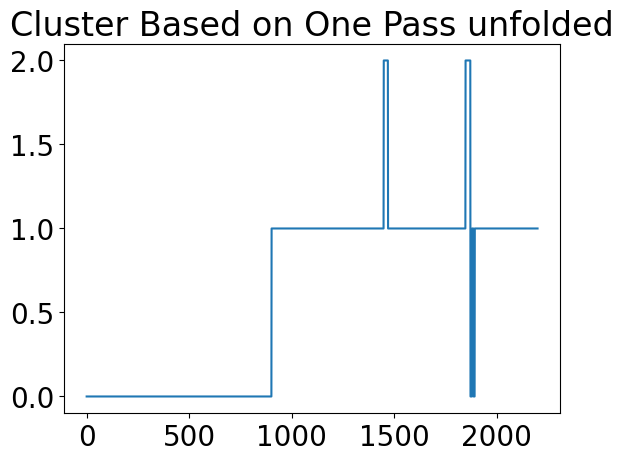

In [26]:
kmeans_onepass_fast = KMeans(n_clusters=3,n_init=1).fit(tl.unfold(np.real(T_hat_one_pass_fast),2))
plt.title("Cluster Based on One Pass unfolded")
plt.plot(kmeans_onepass_fast.labels_)

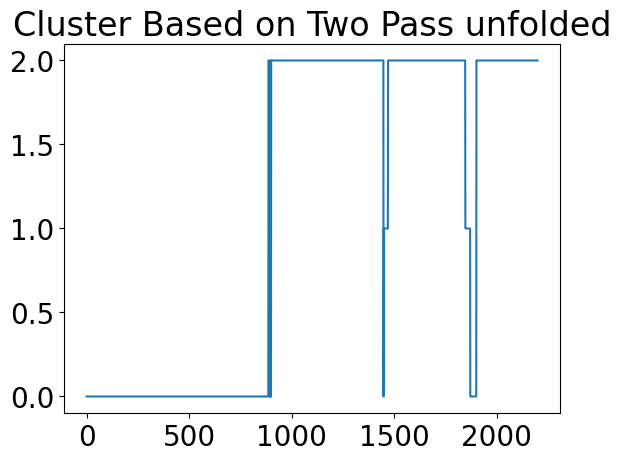

In [27]:
kmeans_twopass_fast = KMeans(n_clusters=3,n_init=1).fit(tl.unfold(np.real(T_hat_two_pass_fast),2))
plt.title("Cluster Based on Two Pass unfolded")
plt.plot(kmeans_twopass_fast.labels_)

This figure colors the classes and lays them out for each frame - we can see that the walking in front of the scene segements are identifiable in all cases

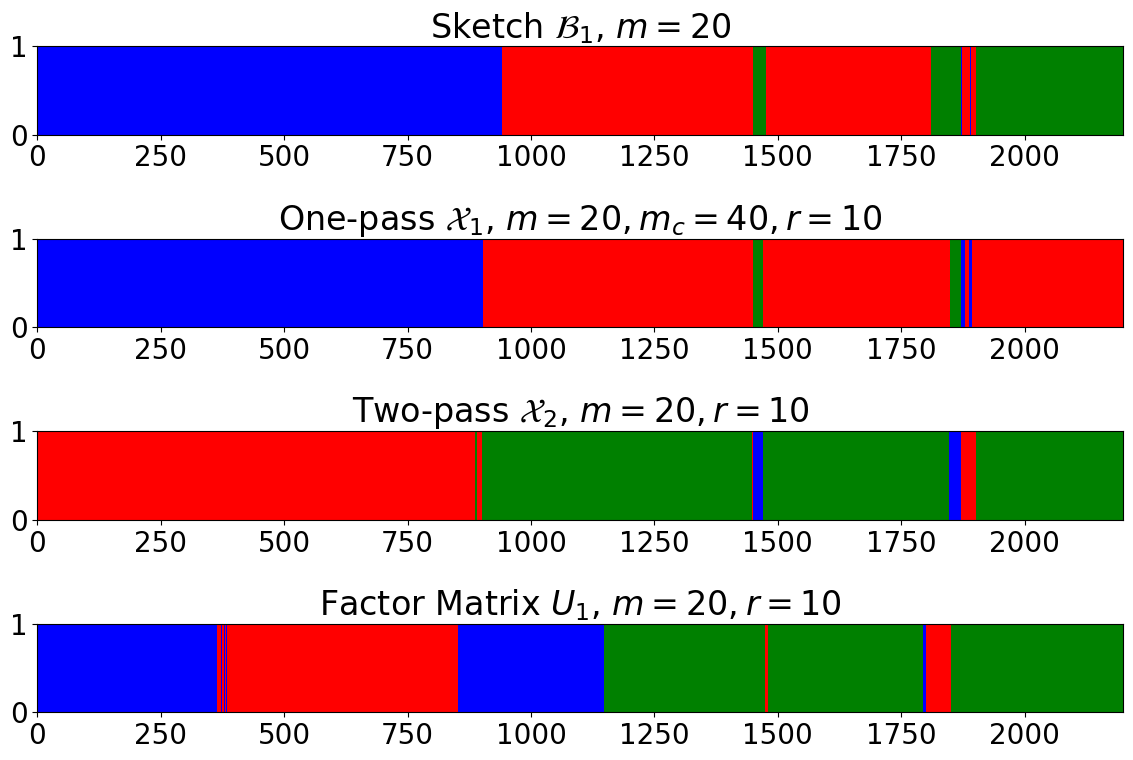

In [33]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(411)


# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(video.shape[2])
])

# set data, colormap and color limits
cmap = ListedColormap([
    'b', 'r', 'g'
])

col.set_array(kmeans_sketch_fast.labels_)
col.set_cmap(cmap)
ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(0,2200)
ax.set_title(r"Sketch $\mathcal{B}_1$, $m=20$")

ax = fig.add_subplot(412)


# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(video.shape[2])
])

# set data, colormap and color limits
cmap = ListedColormap([
    'b', 'r', 'g'
])

col.set_array(kmeans_onepass_fast.labels_)
col.set_cmap(cmap)
ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(0,2200)
ax.set_title(r"One-pass $\mathcal{X}_1$, $m=20, m_c = 40, r=10$")


ax = fig.add_subplot(413)

# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(video.shape[2])
])

# set data, colormap and color limits
cmap = ListedColormap([
    'r', 'b', 'g'
])

col.set_array(kmeans_twopass_fast.labels_)
col.set_cmap(cmap)
ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(0,2200)
ax.set_title(r"Two-pass $\mathcal{X}_2$, $m=20, r=10$")

ax = fig.add_subplot(414)


# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(video.shape[2])
])

# set data, colormap and color limits
cmap = ListedColormap([
    'r', 'b', 'g'
])

col.set_array(kmeans_factor_fast.labels_)
col.set_cmap(cmap)

ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(0,2200)
ax.set_title(r"Factor Matrix $U_1$, $m=20, r=10$")
plt.tight_layout()


Here are measurement and recovery that mixes and matches different types of measurement matrices to create a hybrid ensemble. We also increase the size of the measurements and the rank truncation. Additionally, the method relies on the original tensor being loaded in memory all at once vice streaming frame at a time as was done above.

In [34]:
#Better accuracy for reconstruction with larger allocations for sketching dimension and runk truncation
dim=3
M_c = (600,600,600)
R = (50,50,50)
M = (300,300,300)

#Create two measurment ensembles, one gaussian, one RFD
side_lengths = video.shape  
A_kron_g = loo.measurement_ensemble(dim,side_lengths,M_c,M,loo.my_random_matrix_generator,typ='g')
A_kron_rfd = loo.measurement_ensemble(dim,side_lengths,M_c,M,loo.my_random_matrix_generator,typ='real_rfd')

#Mix and match the types of ensembles by mode to create a hybrid ensemble
A_kron_slow = A_kron_g
A_kron_slow[1][0] = A_kron_rfd[1][0]
A_kron_slow[2][0] = A_kron_rfd[2][0]
A_kron_slow[3][0] = A_kron_rfd[3][0]

#sketch the tensor
starttime = timeit.default_timer()
B_kron_slow = loo.measure_tensor(video,A_kron_slow,mode='kron')
print("sketch time: ", timeit.default_timer() - starttime)

#Recover factor matrices /one-pass
starttime = timeit.default_timer()
S_tilde,U = loo.lsmlsvd_brks(A_kron_slow,B_kron_slow,R,mode='kron')    
T_hat_one_pass_slow = tl.tucker_tensor.tucker_to_tensor((S_tilde,U))
print("recover time: ", timeit.default_timer() - starttime)

rel_error_one_pass = loo.eval_rerr(video,T_hat_one_pass_slow,video)
print("Relative Error of one pass:", rel_error_one_pass)

#Calculate a more accurate core with a second pass
T_hat_two_pass_slow = tl.tucker_tensor.tucker_to_tensor((tl.tenalg.multi_mode_dot(video,U,transpose=True),U))
rel_error_two_pass = loo.eval_rerr(video,T_hat_two_pass_slow,video)
print("Relative Error of two pass:", rel_error_two_pass)

sketch time:  682.5280283223838
recover time:  1189.3400964811444
Relative Error of one pass: 0.30205899819447385
Relative Error of two pass: 0.29740946432517285


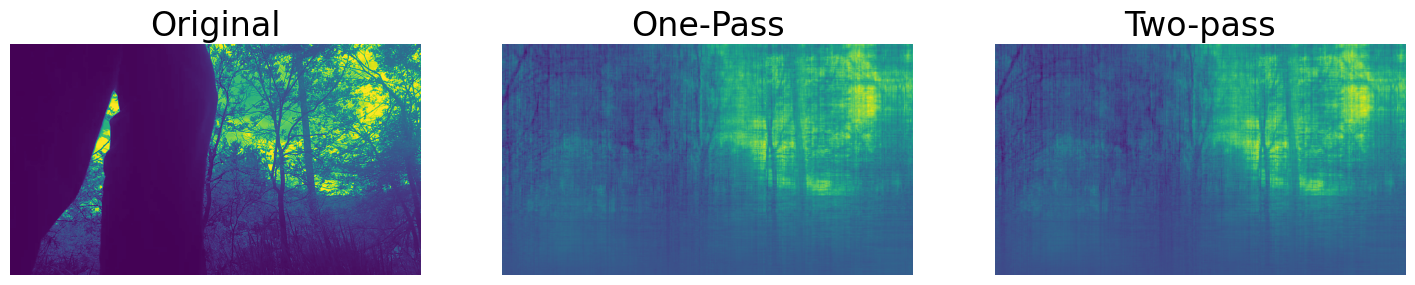

In [37]:
fig, ax = plt.subplots(1,3, figsize=(18,8))
plt.rcParams['font.size'] = 20

plt.subplot(1,3,1)
plt.axis('off')
plt.title('Original')
plt.imshow(np.real(video)[:,:,1454])

plt.subplot(1,3,2)
plt.axis('off')
plt.title('One-Pass')
plt.imshow(np.real(T_hat_one_pass_slow)[:,:,1454])

plt.subplot(1,3,3)
plt.axis('off')
plt.title('Two-pass')

plt.imshow(np.real(T_hat_two_pass_slow)[:,:,1454])
plt.show()